In [1]:
# import libraries
import os
import json
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
# import data
df = pd.read_csv('data/tracks_1000Unique+_with_duplicates.csv', index_col=False)
df.drop_duplicates('track_id', keep='first', inplace=True)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [3]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

### This Version will be working with 1000 Samples for each Genre

In [4]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,genre,popularity,duplicated_x,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,duplicated_y
0,blues,77.0,False,0.274,0.348,5,-8.631,1,0.0293,0.547000,0.013300,0.3340,0.328,87.430,179693,3,False
1,blues,77.0,False,0.756,0.401,7,-10.702,0,0.0526,0.582000,0.011000,0.0541,0.514,101.954,199396,4,False
2,blues,74.0,False,0.581,0.687,6,-5.400,1,0.1050,0.229000,0.000000,0.1090,0.187,76.014,240600,4,False
3,blues,75.0,False,0.635,0.184,8,-10.785,1,0.0456,0.665000,0.000000,0.1460,0.177,128.424,240200,4,False
4,blues,75.0,False,0.477,0.433,11,-6.473,0,0.0247,0.689000,0.000195,0.1510,0.611,82.520,156653,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,techno,29.0,False,0.732,0.875,4,-5.842,0,0.0326,0.126000,0.000234,0.2200,0.933,132.987,214960,4,False
9996,techno,49.0,False,0.738,0.816,4,-6.304,0,0.0322,0.000877,0.785000,0.1340,0.884,129.998,198793,4,False
9997,techno,35.0,False,0.610,0.875,5,-5.455,0,0.0333,0.028300,0.908000,0.1140,0.873,144.999,309023,4,False
9998,techno,44.0,False,0.756,0.527,8,-11.861,1,0.0428,0.002010,0.509000,0.1120,0.248,119.996,416500,4,False


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names_out()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
y.columns = y.columns.str.replace("genre_", "") # remove prefix
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


10

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
feature_names = ct.get_feature_names_out()
X_train = X_train_scaled
X_test  = X_test_scaled

In [7]:
feature_names

array(['stdscaled__popularity', 'stdscaled__danceability',
       'stdscaled__energy', 'stdscaled__key', 'stdscaled__loudness',
       'stdscaled__mode', 'stdscaled__speechiness',
       'stdscaled__acousticness', 'stdscaled__instrumentalness',
       'stdscaled__liveness', 'stdscaled__valence', 'stdscaled__tempo',
       'stdscaled__duration_ms', 'stdscaled__time_signature',
       'remainder__duplicated_x', 'remainder__duplicated_y'], dtype=object)

In [8]:
y_train_rap = y_train.rap
y_train.columns

Index(['blues', 'classical', 'electronic', 'funk', 'jazz', 'metal', 'r&b',
       'rap', 'rock', 'techno'],
      dtype='object')

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [10]:
classifiers = [
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('SVC', SVC(random_state=42))
]

result = {}
print("Predicting Rap!")
for gen in y_train.columns:
    for name, classifier in classifiers:
        y_target = y_train[gen]
        scores = [round(x,2) for x in cross_val_score(classifier, X_train, y_train[gen], cv=3, scoring='accuracy')]
        _tmp = {"min":min(scores), "max":max(scores), "mean":round(np.mean(scores),2)}
        print(f"cross_val_score: [{gen}]-> {name}: {_tmp}")
        classifier.fit(X_train, y_target)
    _genre_result = {}
    for name, classifier in classifiers:
        y_pred = classifier.predict(X_test)
        _score = accuracy_score(y_test[gen], y_pred)
        print(f"test-df: [{gen}]-> {name}: {round(_score, 2)}")
        _genre_result[name] = _score
    result[gen] = _genre_result

Predicting Rap!
cross_val_score: [blues]-> LogisticRegression: {'min': 0.9, 'max': 0.9, 'mean': 0.9}
cross_val_score: [blues]-> KNeighborsClassifier: {'min': 0.89, 'max': 0.91, 'mean': 0.9}
cross_val_score: [blues]-> DecisionTreeClassifier: {'min': 0.87, 'max': 0.88, 'mean': 0.87}
cross_val_score: [blues]-> RandomForestClassifier: {'min': 0.91, 'max': 0.92, 'mean': 0.92}
cross_val_score: [blues]-> SVC: {'min': 0.9, 'max': 0.9, 'mean': 0.9}
test-df: [blues]-> LogisticRegression: 0.9
test-df: [blues]-> KNeighborsClassifier: 0.89
test-df: [blues]-> DecisionTreeClassifier: 0.87
test-df: [blues]-> RandomForestClassifier: 0.91
test-df: [blues]-> SVC: 0.9
cross_val_score: [classical]-> LogisticRegression: {'min': 0.98, 'max': 0.98, 'mean': 0.98}
cross_val_score: [classical]-> KNeighborsClassifier: {'min': 0.97, 'max': 0.98, 'mean': 0.98}
cross_val_score: [classical]-> DecisionTreeClassifier: {'min': 0.96, 'max': 0.97, 'mean': 0.97}
cross_val_score: [classical]-> RandomForestClassifier: {'min'

In [11]:
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [12]:
#result
y_test.columns
result

{'blues': {'LogisticRegression': 0.896,
  'KNeighborsClassifier': 0.8925,
  'DecisionTreeClassifier': 0.8745,
  'RandomForestClassifier': 0.913,
  'SVC': 0.8965},
 'classical': {'LogisticRegression': 0.9785,
  'KNeighborsClassifier': 0.978,
  'DecisionTreeClassifier': 0.964,
  'RandomForestClassifier': 0.9825,
  'SVC': 0.9825},
 'electronic': {'LogisticRegression': 0.9025,
  'KNeighborsClassifier': 0.9045,
  'DecisionTreeClassifier': 0.8765,
  'RandomForestClassifier': 0.917,
  'SVC': 0.904},
 'funk': {'LogisticRegression': 0.9045,
  'KNeighborsClassifier': 0.9015,
  'DecisionTreeClassifier': 0.8725,
  'RandomForestClassifier': 0.9245,
  'SVC': 0.907},
 'jazz': {'LogisticRegression': 0.894,
  'KNeighborsClassifier': 0.908,
  'DecisionTreeClassifier': 0.88,
  'RandomForestClassifier': 0.9195,
  'SVC': 0.911},
 'metal': {'LogisticRegression': 0.905,
  'KNeighborsClassifier': 0.904,
  'DecisionTreeClassifier': 0.9,
  'RandomForestClassifier': 0.942,
  'SVC': 0.907},
 'r&b': {'LogisticRegr

<Figure size 432x288 with 0 Axes>

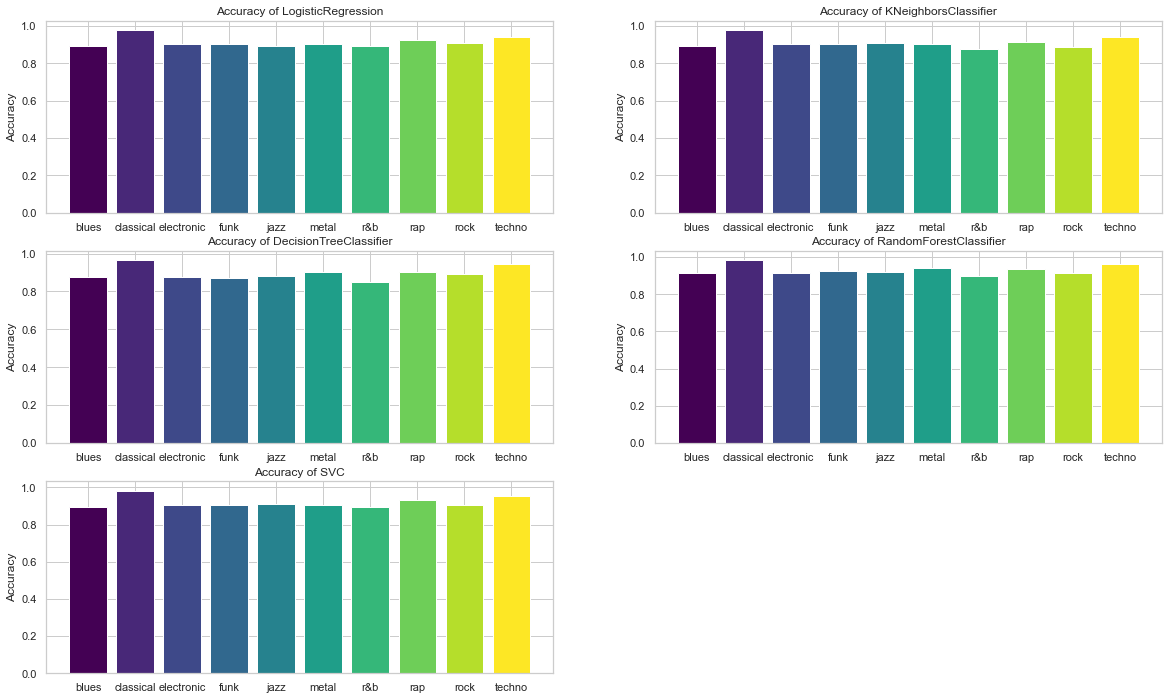

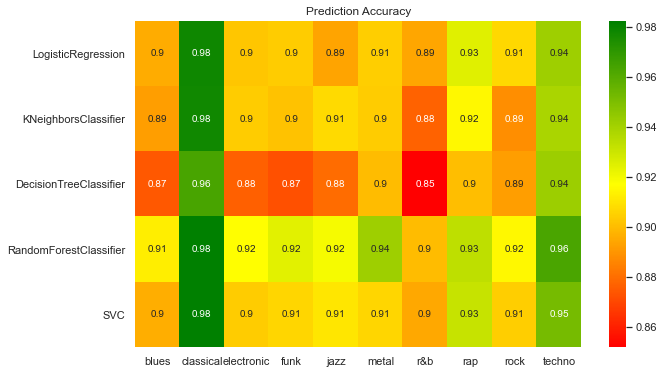

<Figure size 432x288 with 0 Axes>

In [13]:
# PLOT CURRENT PERFORMANCE
reorganized = {}
_genres = y_test.columns
for g in _genres:
    _tmp = result[g]
    for _name in _tmp.keys():
        _dictArr = reorganized.get(_name, [])
        _dictArr += [_tmp[_name]] 
        reorganized[_name] = _dictArr

def MULTI_PLOT(_data : dict):
    global y_test
    colormap = plt.cm.get_cmap('viridis', len(y_test.columns))
    data_for_heatmap = {}
    counter = 0
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))
    for key in reorganized.keys():
        row = counter //2
        col = counter % 2
        data_for_heatmap[key] = []
        _to_display_X = []
        _to_display_Y = []    
        for genre_index in range(len(y_test.columns)):
            genre = y_test.columns[genre_index]
            _to_display_X += [ genre ]
        _to_display_Y = _data[key]
        ax[row][col].bar(_to_display_X, _to_display_Y, color=colormap(range(len(y_test.columns))))
        ax[row][col].set_title("Accuracy of "+ key)
        ax[row][col].set_ylabel("Accuracy")
        data_for_heatmap[key] = _to_display_Y
        counter += 1
    ax[-1][-1].remove()# last one is empty!
MULTI_PLOT(reorganized)
# Bonus

from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['red', 'yellow', 'green'])
sns.heatmap(pd.DataFrame(result), annot=True, cmap=cmap, annot_kws={'fontsize': 10})
plt.title("Prediction Accuracy")
plt.figure()

In [14]:
pd.DataFrame(result).to_csv("genre-classification/data/model_performance_1k.csv")

In [15]:
#visualize diffs
performance_1k = pd.DataFrame(result)
performance_100 = pd.read_csv("genre-classification/data/model_performance_100.csv", index_col=0)
display(performance_100.head())
performance_1k.head()

,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.886139,0.975248,0.876238,0.950495,0.896040,0.876238,0.905941,0.965347,0.925743,0.940594
KNeighborsClassifier,0.905941,0.970297,0.891089,0.930693,0.910891,0.881188,0.905941,0.925743,0.920792,0.945545
DecisionTreeClassifier,0.910891,0.975248,0.881188,0.905941,0.871287,0.920792,0.900990,0.965347,0.945545,0.930693
RandomForestClassifier,0.896040,0.980198,0.915842,0.965347,0.910891,0.945545,0.935644,0.975248,0.945545,0.945545
SVC,0.881188,0.970297,0.891089,0.940594,0.900990,0.876238,0.910891,0.955446,0.930693,0.950495


,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.8960,0.9785,0.9025,0.9045,0.8940,0.905,0.8945,0.9250,0.9075,0.9420
KNeighborsClassifier,0.8925,0.9780,0.9045,0.9015,0.9080,0.904,0.8770,0.9155,0.8885,0.9390
DecisionTreeClassifier,0.8745,0.9640,0.8765,0.8725,0.8800,0.900,0.8520,0.9005,0.8925,0.9425
RandomForestClassifier,0.9130,0.9825,0.9170,0.9245,0.9195,0.942,0.9000,0.9340,0.9155,0.9635
SVC,0.8965,0.9825,0.9040,0.9070,0.9110,0.907,0.8950,0.9320,0.9050,0.9520


Int64Index([6252, 4684, 1731, 4742, 4521, 6340,  576, 5202, 6363,  439,
            ...
             132, 7722, 8458,  964, 8719, 6412, 8285, 7853, 1095, 6929],
           dtype='int64', length=2000)

<Figure size 432x288 with 0 Axes>

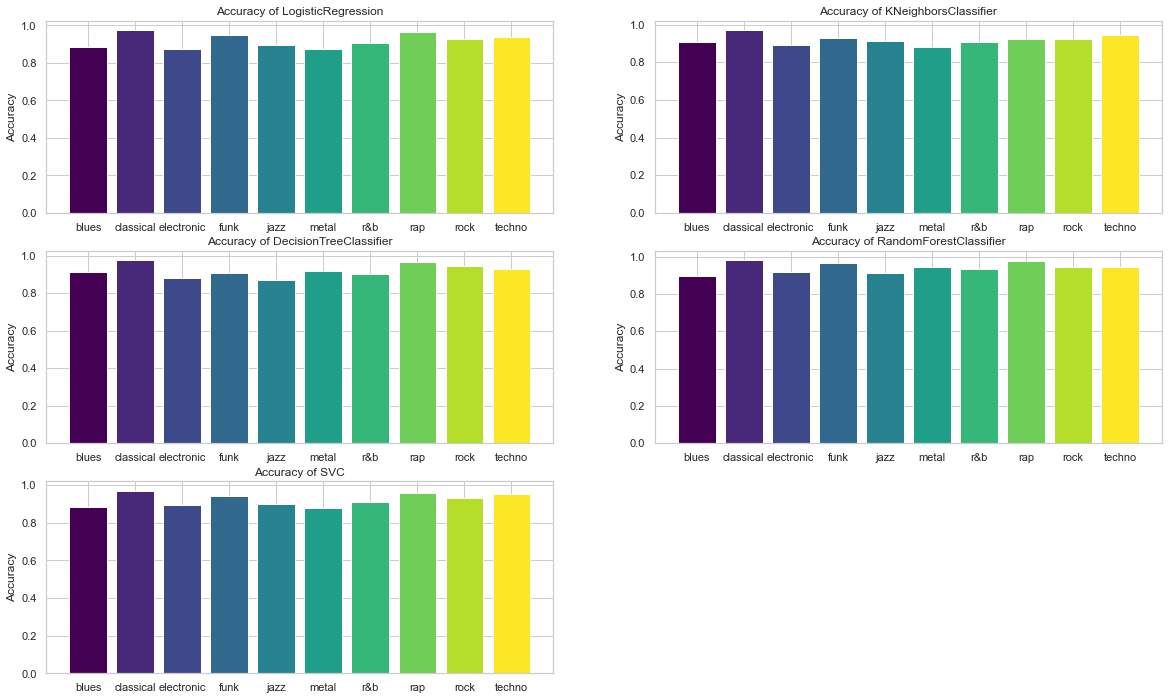

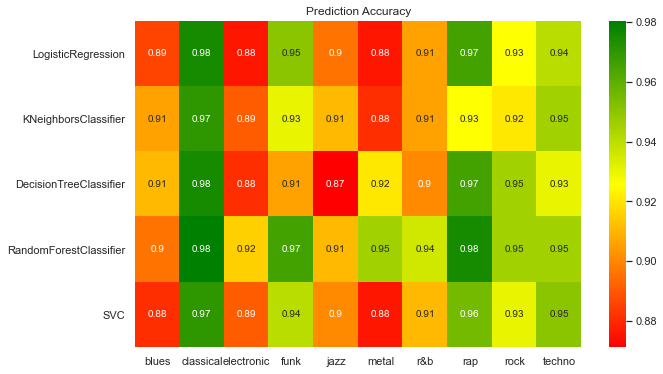

<Figure size 432x288 with 0 Axes>

In [16]:
reorganized = {}
_genres = y_test.columns
display(y_test.index)
for g in _genres:
    _tmp = result[g]
    for _name in _tmp.keys():
        _dictArr = reorganized.get(_name, [])
        _dictArr += [performance_100.loc[_name, g]]
        reorganized[_name] = _dictArr
MULTI_PLOT(reorganized)

from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['red', 'yellow', 'green'])
sns.heatmap(performance_100, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
# Plot data on a logarithmic scale
plt.title("Prediction Accuracy")
plt.figure()

In [17]:
performance_diff = performance_1k - performance_100
performance_diff

,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.009861,0.003252,0.026262,-0.045995,-0.002040,0.028762,-0.011441,-0.040347,-0.018243,0.001406
KNeighborsClassifier,-0.013441,0.007703,0.013411,-0.029193,-0.002891,0.022812,-0.028941,-0.010243,-0.032292,-0.006545
DecisionTreeClassifier,-0.036391,-0.011248,-0.004688,-0.033441,0.008713,-0.020792,-0.048990,-0.064847,-0.053045,0.011807
RandomForestClassifier,0.016960,0.002302,0.001158,-0.040847,0.008609,-0.003545,-0.035644,-0.041248,-0.030045,0.017955
SVC,0.015312,0.012203,0.012911,-0.033594,0.010010,0.030762,-0.015891,-0.023446,-0.025693,0.001505


<Figure size 432x288 with 0 Axes>

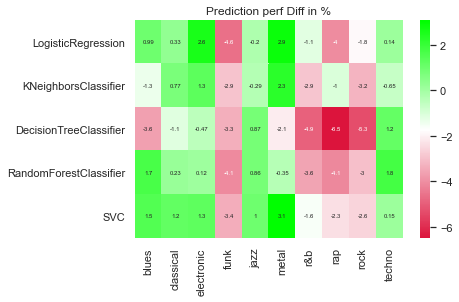

<Figure size 432x288 with 0 Axes>

In [18]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'white', 'lime'])
sns.heatmap(performance_diff * 100.0, annot=True, cmap=cmap, annot_kws={'fontsize': 6})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()